In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
# import pca
from sklearn.decomposition import PCA, FactorAnalysis

# Read in the data
data = pd.read_stata('Cecilia/Eurobarometer_91_5.dta', convert_categoricals=False)
q_selection = ['qf1', 'qf2', 'qa10_1', 'qa10_2', 'qa10_3', 'qa10_6', 'qd1a_3', 'qd2_1', 'qd2_2','qg1']
data_selection = data[q_selection]
for q in ['qf1','qf2']:
    mask = data_selection[q]==2
    data_selection.loc[data_selection[q]==3, q] = 2
    data_selection.loc[mask, q] = 3
    data_selection.loc[data_selection[q]>3, q] = np.nan

data_selection.loc[data_selection['qg1']==2, 'qg1'] = 0

for q in ['qa10_1','qa10_2','qa10_3','qa10_6','qd1a_3','qd2_1','qd2_2']:
    data_selection.loc[data_selection['qg1'].isna(), q] = np.nan
    data_selection.loc[data_selection[q]>4, q] = np.nan

In [3]:
data_selection.describe()

,qf1,qf2,qa10_1,qa10_2,qa10_3,qa10_6,qd1a_3,qd2_1,qd2_2,qg1
count,27076.000000,25721.000000,25544.000000,25731.000000,25300.000000,24928.000000,26897.000000,27167.000000,27095.000000,27464.000000
mean,1.488625,1.432992,2.149820,2.119894,2.255455,2.248195,2.333309,1.977914,2.347407,0.546461
std,0.675915,0.820252,0.733899,0.751501,0.778937,0.764253,0.886957,0.895413,0.854837,0.497846
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,0.000000
50%,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000
75%,2.000000,1.000000,3.000000,2.000000,3.000000,3.000000,3.000000,2.000000,3.000000,1.000000
max,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,1.000000


In [14]:
px.imshow(data_selection.corr(), x=data_selection.columns, y=data_selection.columns, color_continuous_scale='RdBu', title='Correlation Matrix', text_auto='.2f')

In [15]:
px.imshow(data_selection.cov(), x=data_selection.columns, y=data_selection.columns, color_continuous_scale='RdBu', title='Covariance Matrix', text_auto='.2f')

In [43]:
px.histogram(data_selection, x='qf1', color='qg1', barmode='overlay', title='qf1')

In [41]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Create trace for correlation matrix
trace1 = go.Heatmap(z=data_selection.corr(), x=data_selection.columns, y=data_selection.columns, colorscale='RdBu', colorbar=dict(title='Correlation'))

# Create trace for covariance matrix
trace2 = go.Heatmap(z=data_selection.cov(), x=data_selection.columns, y=data_selection.columns, colorscale='RdBu', colorbar=dict(title='Covariance'))

# Create subplot figure
fig = make_subplots(rows=1, cols=2, subplot_titles=('Correlation Matrix', 'Covariance Matrix'))

# Add traces to subplot figure
fig.add_trace(trace1, row=1, col=1)
fig.add_trace(trace2, row=1, col=2)

# Update subplot layout
fig.update_layout(height=600, width=1000, title_text='Correlation and Covariance Matrix')

# Show plot
fig.show()


In [75]:
data_experiment = data[['qa13_1','qa13_2','qa13_3','qa13_4','qa13_5','qg1']].copy()
data_experiment = data_experiment[~data_selection['qg1'].isna()]
data_experiment[data_experiment==2] = 0
data_experiment[data_experiment==3] = np.nan
data_experiment['score'] = data_experiment[['qa13_1','qa13_2','qa13_3','qa13_4','qa13_5']].sum(axis=1)
# qa15t2-qa15t5 from 0 to 3 correct
# add together with other score

In [78]:
px.imshow(data_experiment[['score', 'qg1','qa13_1','qa13_2','qa13_3','qa13_4','qa13_5']].corr())

In [73]:
px.histogram(data_experiment, x='score', title='Score')

In [ ]:
data_selection = data_selection.mask(data_selection==data_selection.max())
# flip the values of qa19a, qa8
data_selection['qa19a'] = data_selection['qa19a'].max() +1 - data_selection['qa19a']
data_selection['qa8'] = data_selection['qa8'].max() +1 - data_selection['qa8']

In [7]:
eu_vote = pd.read_csv('Cecilia/export_table_EPturnout.csv',parse_dates=['Date']).ffill()
nat_vote = pd.read_csv('Cecilia/export_table_nationalturnout.csv',parse_dates=['Date']).ffill()
eu_vote['Year'] = eu_vote['Date'].dt.year
nat_vote['Year'] = nat_vote['Date'].dt.year
year_filter = np.arange(1979,2020,5)

In [9]:
nat_vote_idx = nat_vote[['Country','Year','NatVote%']].drop_duplicates().set_index(['Country','Year'])
eu_vote_idx = eu_vote[['Country','Year','EUVote%']].drop_duplicates().set_index(['Country','Year'])
full_data = pd.concat([nat_vote_idx,eu_vote_idx],axis=1).sort_index().groupby(level='Country').ffill()
full_data['diff'] = full_data['NatVote%'] - full_data['EUVote%']

In [10]:
full_data = full_data.reset_index()
full_data = full_data.loc[full_data['Year'].isin(year_filter),:]

In [11]:
groupt = full_data[['diff','Year']].groupby('Year').mean().loc[year_filter,:]
groupt['min'] = full_data[['diff','Year']].groupby('Year').quantile(0.25).loc[year_filter,:]
groupt['max'] = full_data[['diff','Year']].groupby('Year').quantile(0.75).loc[year_filter,:]

In [6]:
nat_vote_idx = nat_vote[['Country','Year','NatVote%']].drop_duplicates().set_index(['Country','Year'])
eu_vote_idx = eu_vote[['Country','Year','EUVote%']].drop_duplicates().set_index(['Country','Year'])
full_data = pd.concat([nat_vote_idx,eu_vote_idx],axis=1).sort_index().groupby(level='Country').ffill()
full_data['diff'] = full_data['NatVote%'] - full_data['EUVote%']
full_data = full_data.reset_index()
full_data = full_data.loc[full_data['Year'].isin(year_filter),:]
groupt = full_data[['diff','Year']].groupby('Year').mean().loc[year_filter,:]
groupt['min'] = full_data[['diff','Year']].groupby('Year').quantile(0.25).loc[year_filter,:]
groupt['max'] = full_data[['diff','Year']].groupby('Year').quantile(0.75).loc[year_filter,:]

In [8]:
test = eu_vote[['Year','EUVote%']].groupby('Year').mean().loc[year_filter,:]

In [12]:
plot_data = pd.concat([eu_vote[['Year','EUVote%']].groupby('Year').mean().loc[year_filter,:],nat_vote[['Year','NatVote%']].groupby('Year').mean().loc[year_filter,:]],axis=1)
plot_data['EuroGap'] = plot_data['NatVote%'] - plot_data['EUVote%']
lines = px.line(plot_data[['NatVote%','EUVote%']])
bar = px.bar(plot_data['EuroGap'],text_auto='.2s')
fig = go.Figure(data= lines.data + bar.data)
fig.add_trace(go.Scatter(
        x=groupt.index,
        y=groupt['diff'],
        mode='markers',
        name='Mean and Quartiles',
        error_y=dict(
            type='data',
            symmetric=False,
            array=groupt['diff'] - groupt['min'],
            arrayminus=groupt['max'] - groupt['diff'],)
        ))
# set x axis labels
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = year_filter,
        ticktext = year_filter
    ),
    yaxis = dict(
        tickmode = 'array',
        tickvals = np.arange(0,100,10),
        ticktext = [str(x)+'%' for x in np.arange(0,100,10)]
    ),
    autosize=False,
    width=800,
    height=400,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4
    ),
    template='plotly_white',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.2,
        xanchor="right",
        x=0.7
    ),
    title=dict(
        text='Turnout in European and National Elections',
        x=0.5,
        y=0.9
    ),
)
fig.show()

In [76]:
fig = go.Figure(data=go.Scatter(
        x=groupt.index,
        y=groupt['diff'],
        mode='markers',
        error_y=dict(
            type='data',
            symmetric=False,
            array=groupt['diff'] - groupt['min'],
            arrayminus=groupt['max'] - groupt['diff'],)
        ))
fig.show()

In [30]:
data_norm = data_selection.rank(axis=0, method='min', pct=True, na_option='keep')
# fill na with mean values
data_norm = data_norm.fillna(data_norm.mean())

In [31]:
data_norm.describe()

,qa2,qa7,qa8,qa9,qa17,qa19a,qa21,d72_1,d73_2,d78,sd18b
count,26569.000000,26569.000000,26569.000000,26569.000000,26569.000000,26569.000000,26569.000000,26569.000000,26569.000000,26569.000000,26569.000000
mean,0.334440,0.248866,0.423076,0.296657,0.347799,0.413534,0.292736,0.365153,0.289208,0.331341,0.292554
std,0.282427,0.340253,0.314397,0.272543,0.286815,0.333877,0.302383,0.279102,0.295501,0.300097,0.308191
min,0.000038,0.000038,0.000038,0.000039,0.000040,0.000038,0.000039,0.000040,0.000041,0.000038,0.000040
25%,0.052989,0.000038,0.247785,0.000039,0.176042,0.000038,0.088310,0.177261,0.000041,0.077677,0.067294
50%,0.395730,0.000038,0.367985,0.292409,0.176042,0.430664,0.088310,0.177261,0.289208,0.077677,0.067294
75%,0.395730,0.735745,0.693403,0.292409,0.611362,0.688851,0.658540,0.535974,0.496486,0.521831,0.637628
max,0.963215,0.735745,0.966182,0.971422,0.870761,0.947681,0.937317,0.799731,0.903867,0.966591,0.917570


In [ ]:
px.imshow(data_norm.cov())

In [33]:
# run pca on data_selection

pca = PCA()
pca.fit(data_norm)
pca_expl = pd.Series(pca.explained_variance_ratio_)
pca_expl.index = ['PC'+str(i+1) for i in range(len(pca_expl))]
px.bar(pca_expl, title='Explained variance ratio of PCA', labels={'value':'Explained variance ratio', 'index':'PC'}, color_discrete_sequence=['#1f77b4'])

In [35]:
fa = FactorAnalysis()
fa.fit(data_norm)


FactorAnalysis()

In [39]:
output = pd.DataFrame(fa.components_.T, index=data_norm.columns, columns=['F'+str(i) for i in range(len(fa.components_))])
px.imshow(output, labels=dict(x="Factors", y="features"))

# Eurobarometer

In [25]:
import pandas as pd
data2 = pd.read_stata('Eurobarometer_91_5.dta', convert_categoricals=False)

In [26]:
q_selection2 = ['qa13_1','qa13_2','qa13_3','qa13_4','qa13_5']
data2 = data2[q_selection2]

In [27]:
data2[data2==2] = 0
data2[data2==3] = 0
data2[data2==1] = 1

In [28]:
data2['sum'] = data2.sum(axis=1).astype('object')
data2['answered'] = 5-data2.loc[:,['qa13_1','qa13_2','qa13_3','qa13_4','qa13_5']].isna().sum(axis=1)
data2['perc'] = data2['sum']/(data2['answered']+(data2['answered']==0).astype('int'))

In [29]:
data2.describe()

,qa13_1,qa13_2,qa13_3,qa13_4,qa13_5,answered
count,27964.000000,27964.000000,27464.000000,27464.000000,27464.000000,32524.000000
mean,0.938063,0.872693,0.863094,0.755134,0.701100,4.252859
std,0.241045,0.333322,0.343755,0.430016,0.457784,1.756513
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,0.000000,5.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000


In [31]:
import plotly.express as px
px.histogram(data2, x='perc', nbins=20, title='Distribution of the percentage of answered questions')

<Axes: title={'center': 'Count (target)'}, xlabel='sum'>

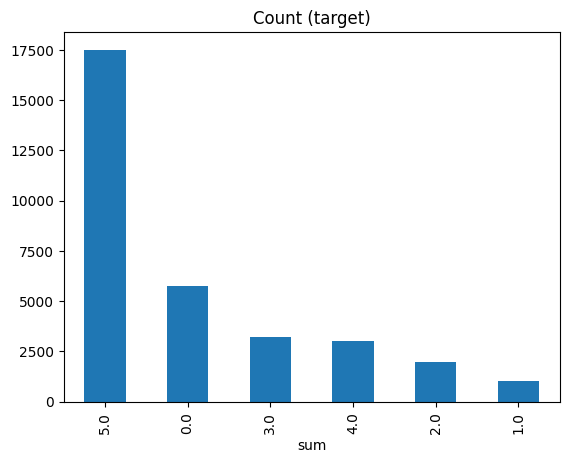

In [29]:
data2.value_counts('sum').plot(kind='bar', title='Count (target)')